# Sentiment Analysis

## Build Model

In [1]:
import pandas as pd

df = pd.read_csv("Data/Genshin_Impact.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)
df.dropna(subset = ["content"], inplace = True)
df.drop_duplicates(keep = "first", inplace = True)
print(str(df.shape[0]) + " comments and their related information are scrapped from Bilibili Game Center.")
df.head()

256361 comments and their related information are scrapped from Bilibili Game Center.


,name,level,datetime,content,grade,up,down,rcount
0,bili_235060966,5,2019-06-07 17:31:06,在？我是第一个预约的吗？,8,21,11,3
1,KAMISAMA是阿笑,5,2019-06-07 17:35:17,期待期待,10,6,12,0
2,遙かなる夢,5,2019-06-07 17:38:56,来了来了,8,5,10,0
3,打倒豆豆,6,2019-06-07 17:46:44,非常的期待,10,5,11,0
4,MitsuharuYosaka,5,2019-06-07 17:47:23,好期待啊,10,5,8,0


In [2]:
import jieba

extra_words = ["氪金", "骗氪", "白嫖", "零氪", "微氪", "又肝", 
               "米哈游", "米卫兵", "云玩家", "出货率", "圣遗物", "海灯节", 
               "开放世界", "未来可期", "文化输出", "3A大作", "数值膨胀", "喂不饱的狼"]

for word in extra_words:
    jieba.add_word(word, freq = df[df["content"].str.contains(word)].shape[0])
    
df.drop(df[df["content"].str.contains("|".join(["---", "———", "2019", "2020", "2021"]))].index, inplace = True)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/qp/xfzzv9sn4cq4q1b3glmz9x4r0000gn/T/jieba.cache
Loading model cost 0.630 seconds.
Prefix dict has been built successfully.


In [3]:
from sklearn.model_selection import train_test_split

test_ratio = 0.2
seed = 123

pos = df[df["grade"] > 6]["content"]
pos_train, pos_test = train_test_split(pos, test_size = test_ratio, random_state = seed, shuffle = True)
textfile = open("Data/pos.txt", "w")
for comment in pos_train:
    textfile.write(comment + "\n")
textfile.close()

neg = df[df["grade"] <= 6]["content"]
neg_train, neg_test = train_test_split(neg, test_size = test_ratio, random_state = seed, shuffle = True)
textfile = open("Data/neg.txt", "w")
for comment in neg_train:
    textfile.write(comment + "\n")
textfile.close()

In [4]:
from snownlp import sentiment
from snownlp import SnowNLP

sentiment.train("Data/neg.txt", "Data/pos.txt")
sentiment.save("/opt/anaconda3/lib/python3.7/site-packages/snownlp/sentiment/sentiment.marshal")
pos_results = [SnowNLP(comment).sentiments for comment in pos_test]
neg_results = [SnowNLP(comment).sentiments for comment in neg_test]

In [5]:
accuracy = []
thresholds = [i / 1000 for i in range(1001)]
for x in thresholds:
    correct = 0
    for result in pos_results:
        if (result >= x):
            correct += 1
    for result in neg_results:
        if (result < x):
            correct += 1
    accuracy.append(correct / (len(pos_test) + len(neg_test)) * 100)
threhold = accuracy.index(max(accuracy)) / 1000
print("Accuracy: " + str(round(max(accuracy), 2)) + "%")

Accuracy: 80.03%


## Apply Model to Video Comments

In [6]:
df = pd.read_csv("Data/Zhong_Li.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)
df.dropna(subset = ["content"], inplace = True)
df.drop_duplicates(keep = "first", inplace = True)
print(str(df.shape[0]) + " comments and their related information are scrapped from Target Video.")
df.head()

101079 comments and their related information are scrapped from Target Video.


,name,level,datetime,content,like,rcount
0,の尼桑,6.0,2020-11-30 12:00:18,有一根绳子，就能爬上山崖\n有一只凯亚，就能渡过大海\n四十岁之前，我已抽普所有卡池\n唯独...,36053.0,100.0
1,无神怜爱的雪国,5.0,2020-11-30 12:00:18,「一份新的契约…好吧，虽然我还在度假，但也可以陪你走一趟，契约书上该签什么名字呢…我有许多名...,1337.0,13.0
2,头号咯噔专家,5.0,2020-11-30 12:00:18,我直接打招呼：嗨 老婆！,336.0,3.0
3,MomoAya哟,6.0,2020-11-30 12:00:19,在坐的各位都能单抽出奇迹,5944.0,203.0
4,磁爆步兵54,5.0,2020-11-30 12:00:20,“被钟离先生缠上了，可就什么办法也没有了”\n我无所谓！,10832.0,53.0


In [7]:
df["date"] = [t.split(" ")[0] for t in list(df["datetime"])]
df["sentiment"] = [1 if SnowNLP(comment).sentiments >= threhold else -1 for comment in list(df["content"])]

### Simple Polarity Analysis

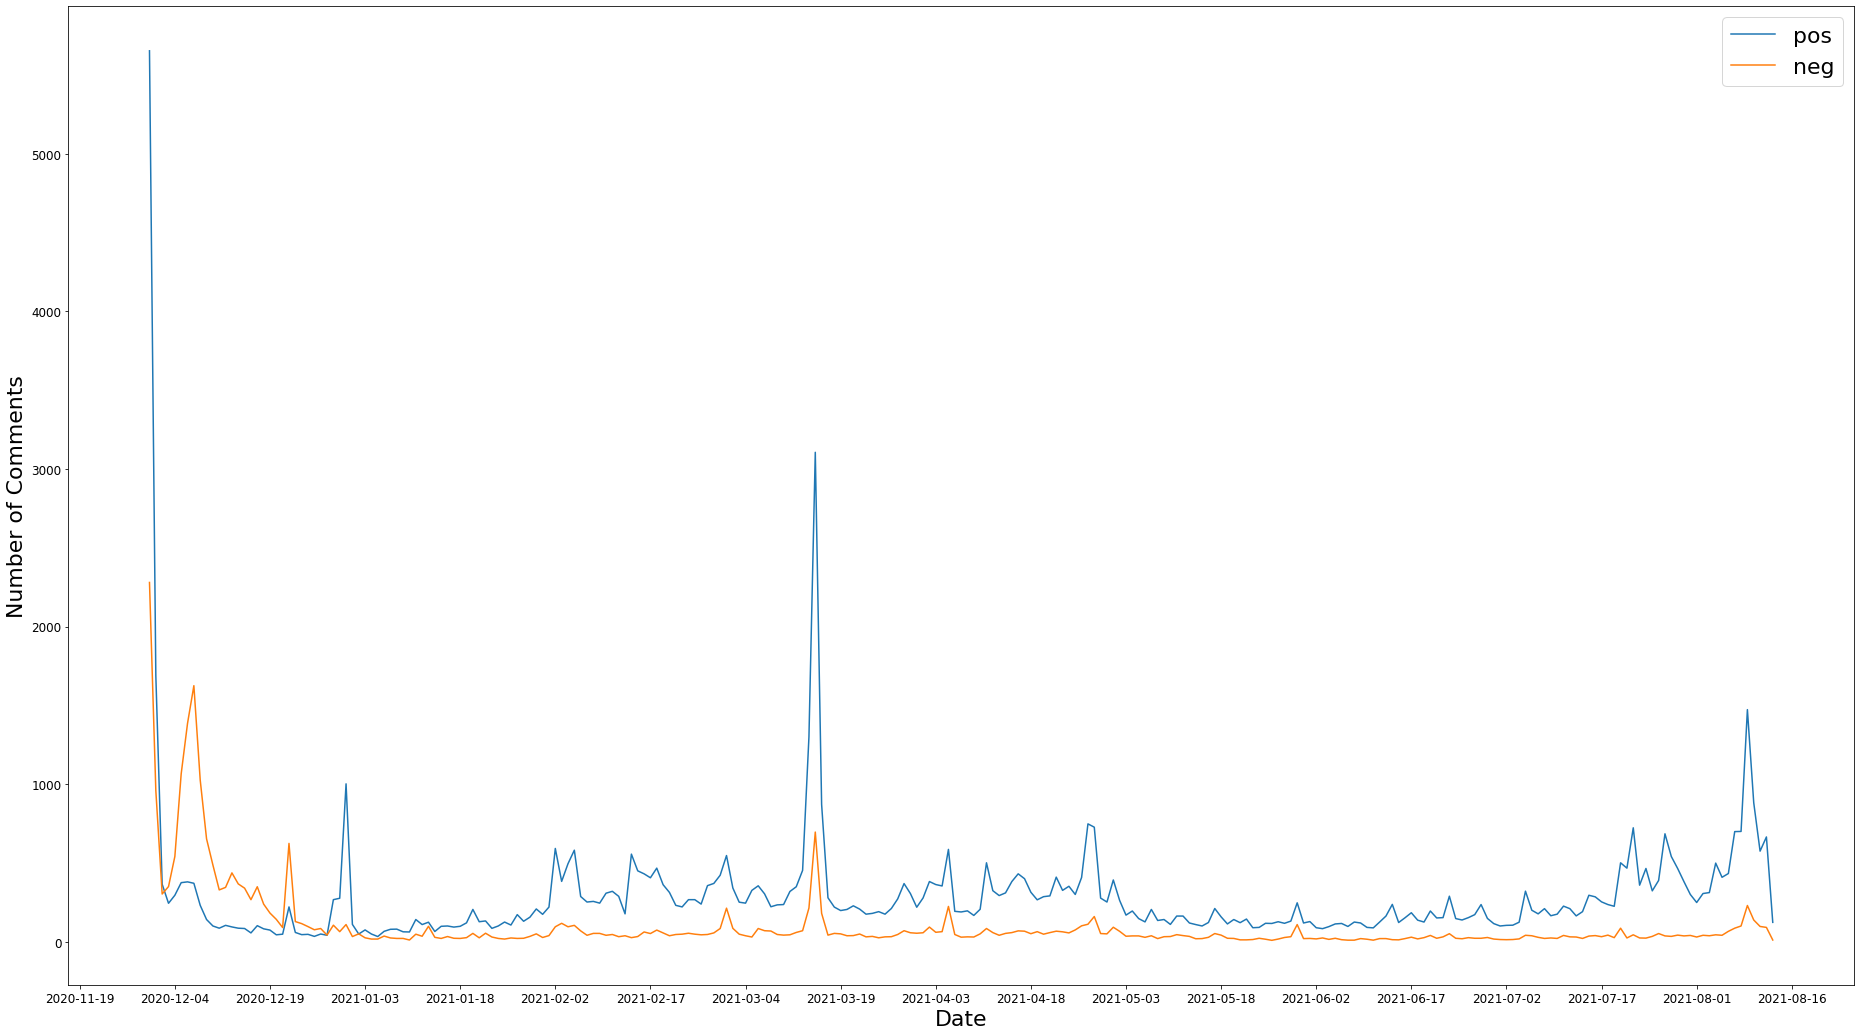

In [20]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 15))
plt.rcParams["figure.figsize"] = (32, 18)
plt.rcParams.update({'font.size': 12})

x = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in list(df["date"].drop_duplicates())]
y1 = df[df["sentiment"] == 1].groupby("date")["content"].count().tolist()
y2 = df[df["sentiment"] == -1].groupby("date")["content"].count().tolist()

plt.plot(x, y1, label = "pos")
plt.plot(x, y2, label = "neg")
plt.legend(fontsize = 22)
plt.xlabel("Date", fontsize = 22)
plt.ylabel("Number of Comments", fontsize = 22)
plt.show()

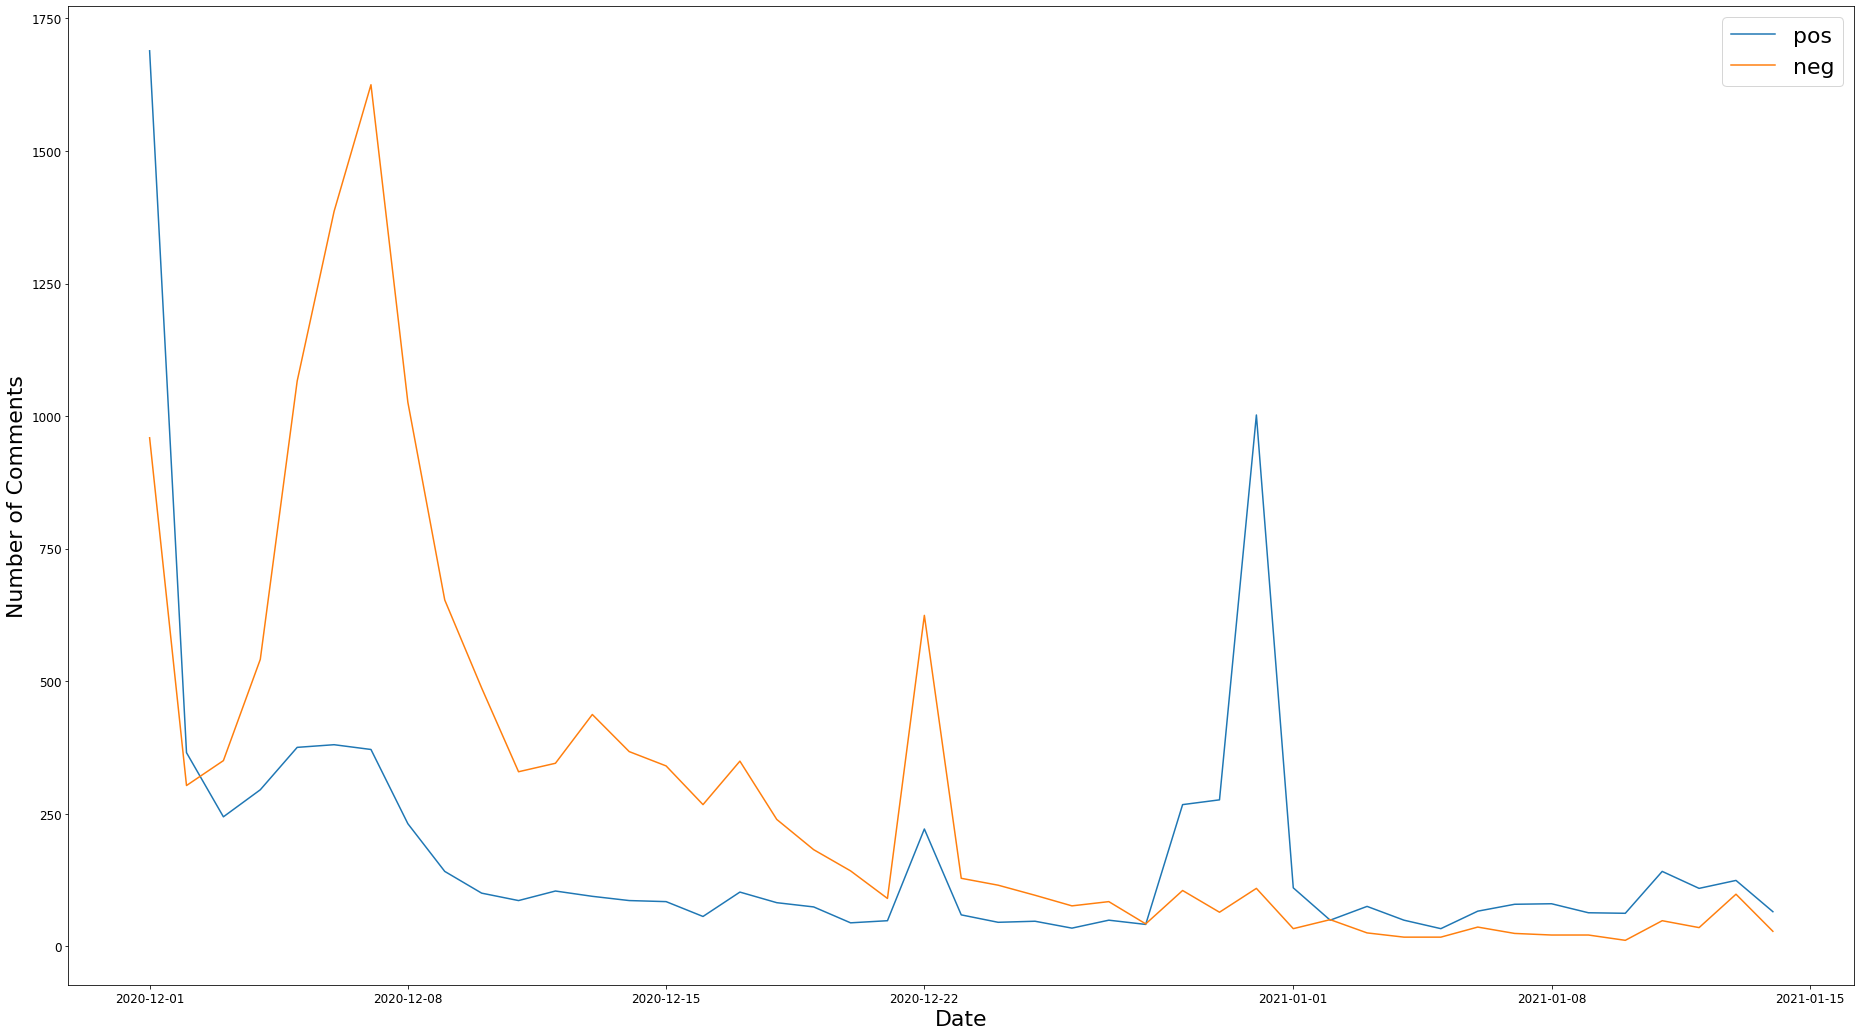

In [21]:
df1 = df[(df["date"] >= "2020-12-01") & (df["date"] < "2021-01-15")]

x = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in list(df1["date"].drop_duplicates())]
y1 = df1[df1["sentiment"] == 1].groupby("date")["content"].count().tolist()
y2 = df1[df1["sentiment"] == -1].groupby("date")["content"].count().tolist()

plt.plot(x, y1, label = "pos")
plt.plot(x, y2, label = "neg")
plt.legend(fontsize = 22)
plt.xlabel("Date", fontsize = 22)
plt.ylabel("Number of Comments", fontsize = 22)
plt.show()

In [22]:
# 钟离PV日配上线
# df[df["date"] == "2020-12-22"].to_csv("Data/20201222.csv")

# 钟离生日
# df[df["date"] == "2020-12-31"].to_csv("Data/20201231.csv")

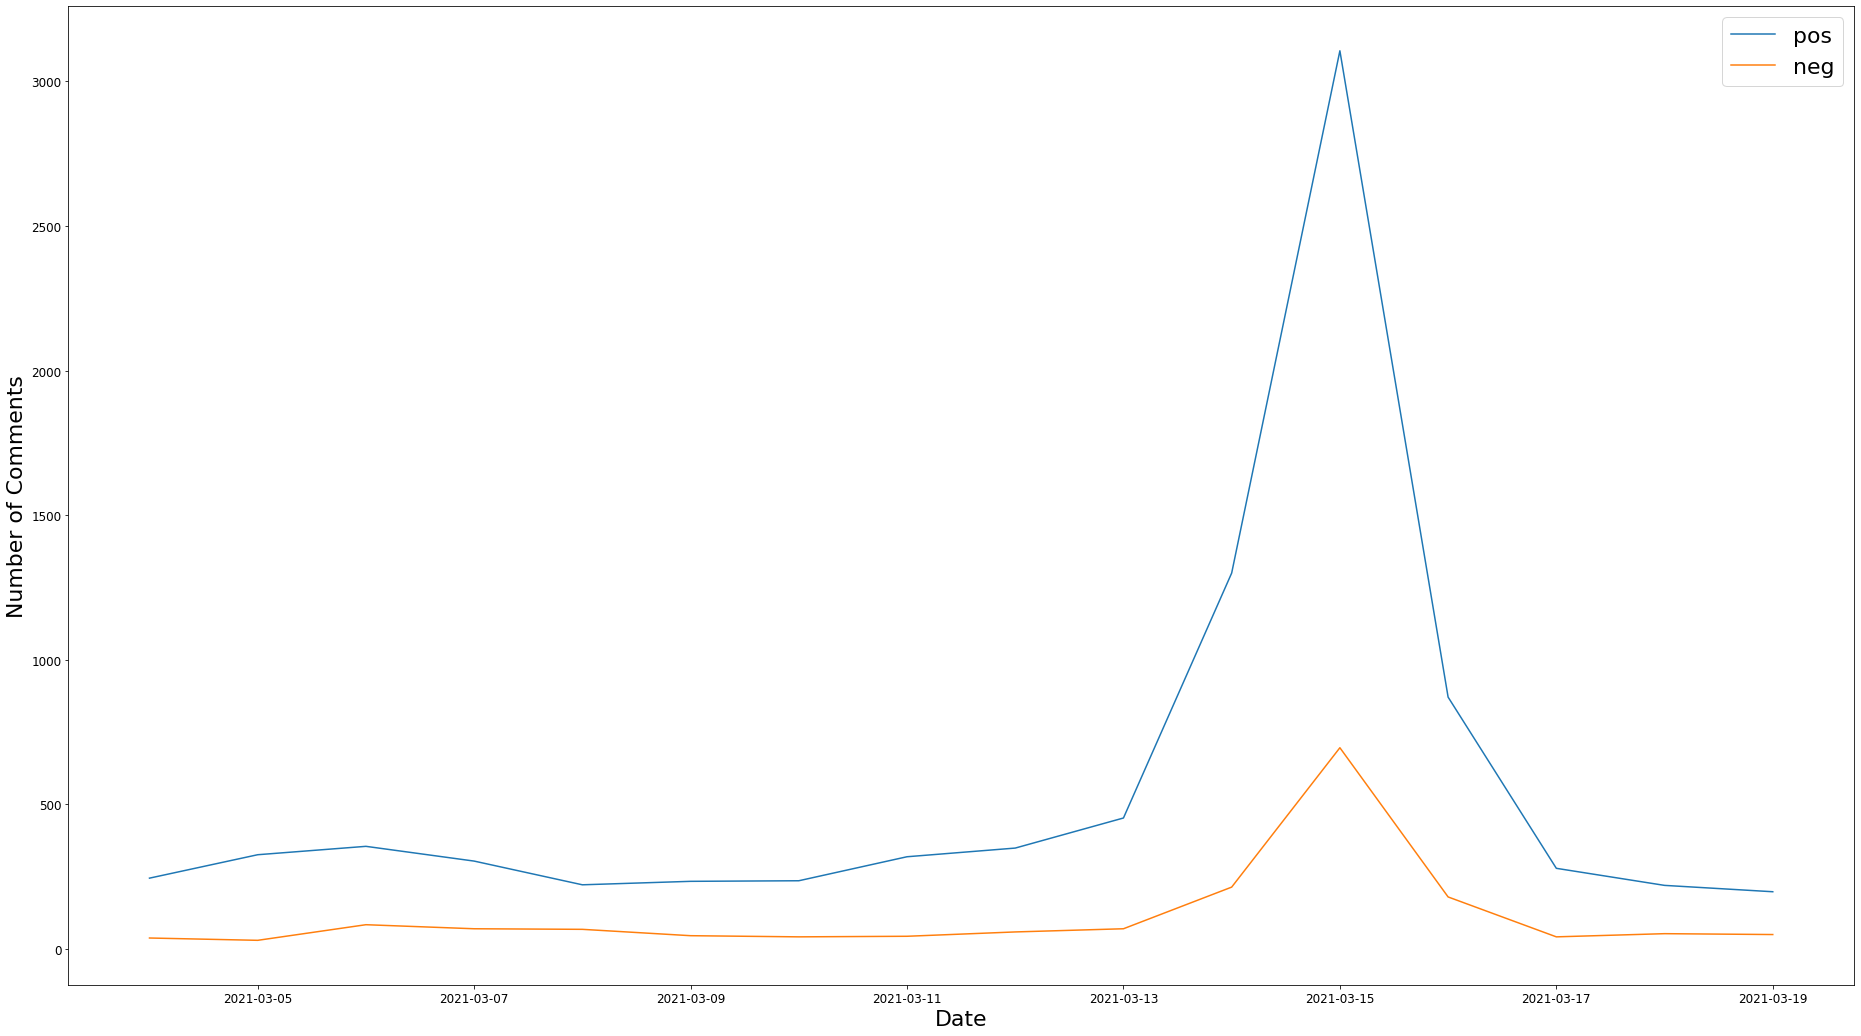

In [23]:
df2 = df[(df["date"] >= "2021-03-04") & (df["date"] < "2021-03-20")]

x = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in list(df2["date"].drop_duplicates())]
y1 = df2[df2["sentiment"] == 1].groupby("date")["content"].count().tolist()
y2 = df2[df2["sentiment"] == -1].groupby("date")["content"].count().tolist()

plt.plot(x, y1, label = "pos")
plt.plot(x, y2, label = "neg")
plt.legend(fontsize = 22)
plt.xlabel("Date", fontsize = 22)
plt.ylabel("Number of Comments", fontsize = 22)
plt.show()

In [24]:
# 钟离PV播放破千万
# df[df["date"] == "2021-03-15"].to_csv("Data/20210315.csv")

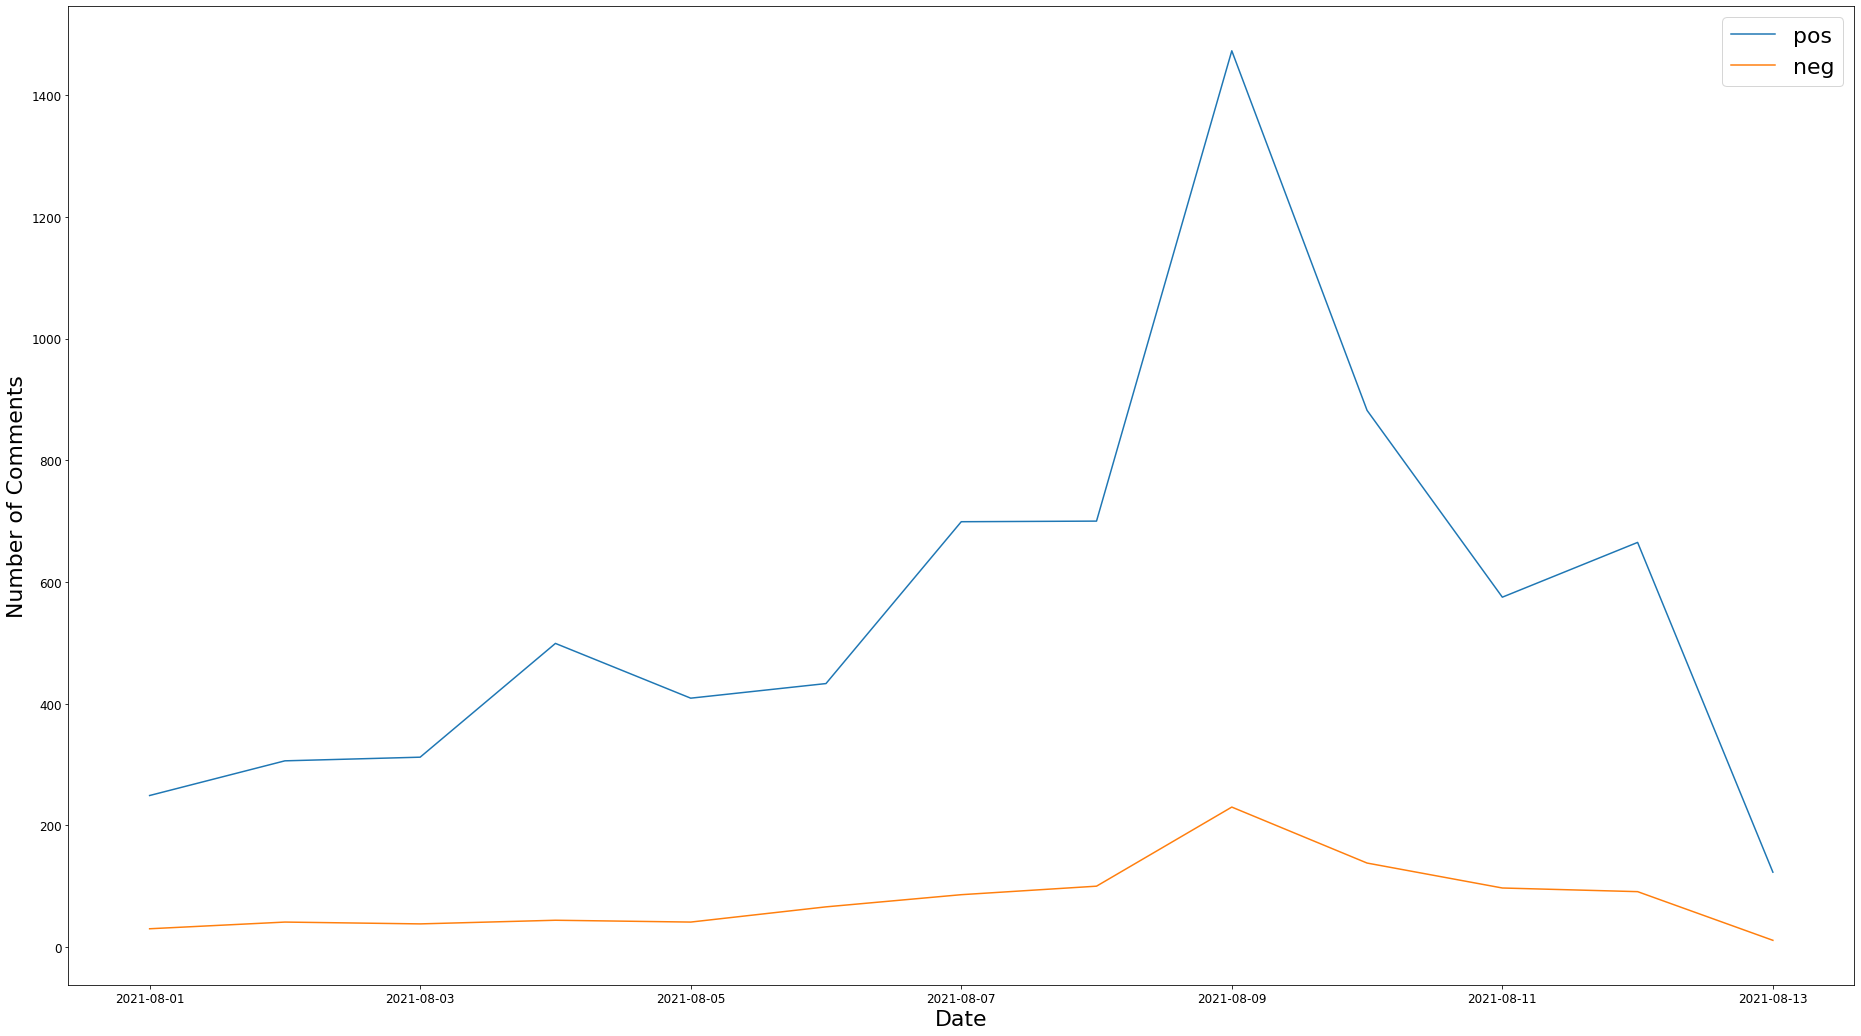

In [25]:
df3 = df[(df["date"] >= "2021-08-01") & (df["date"] < "2021-08-17")]

x = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in list(df3["date"].drop_duplicates())]
y1 = df3[df3["sentiment"] == 1].groupby("date")["content"].count().tolist()
y2 = df3[df3["sentiment"] == -1].groupby("date")["content"].count().tolist()

plt.plot(x, y1, label = "pos")
plt.plot(x, y2, label = "neg")
plt.legend(fontsize = 22)
plt.xlabel("Date", fontsize = 22)
plt.ylabel("Number of Comments", fontsize = 22)
plt.show()

In [26]:
# 钟离PV播放破两千万
# df[df["date"] == "2021-08-09"].to_csv("Data/20210809.csv")

### Take Number of Likes into Consideration

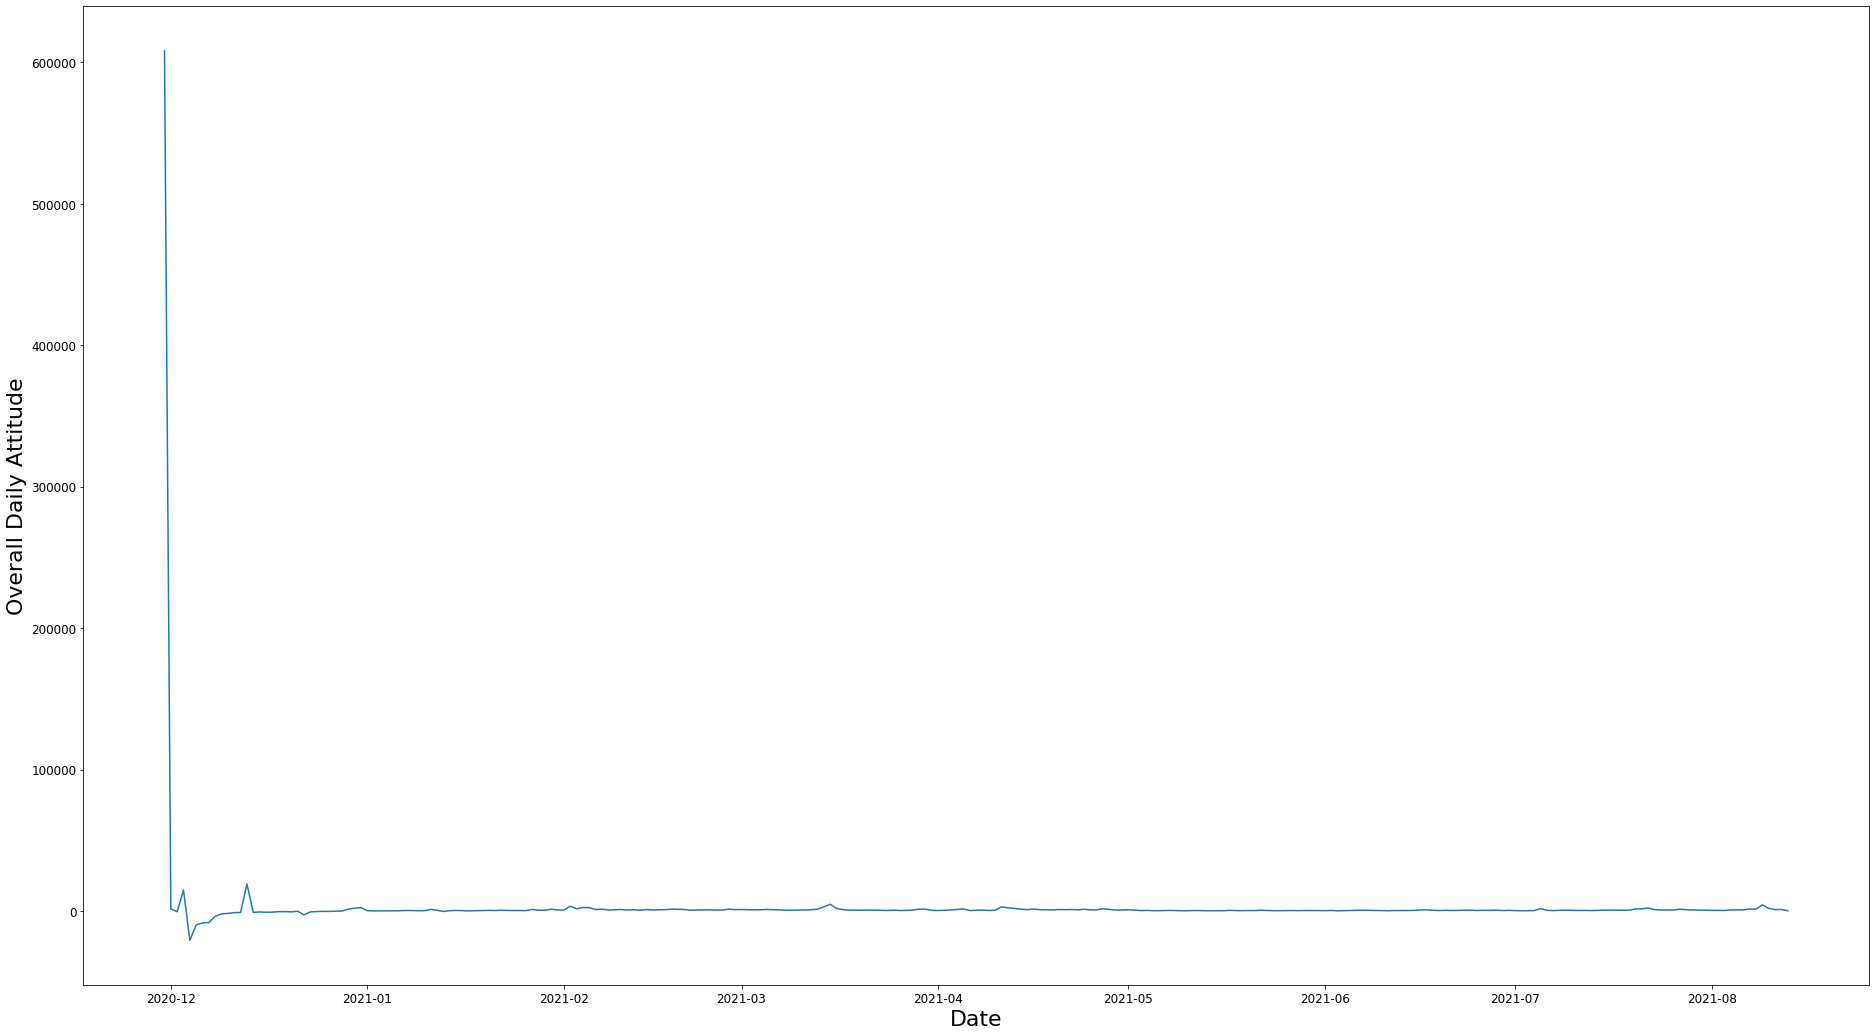

In [27]:
df["overall"] = (df.like + 1) * df.sentiment

x = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in list(df["date"].drop_duplicates())]
y = df.groupby("date")["overall"].sum().tolist()

plt.plot(x, y)
plt.xlabel("Date", fontsize = 22)
plt.ylabel("Overall Daily Attitude", fontsize = 22)
plt.show()

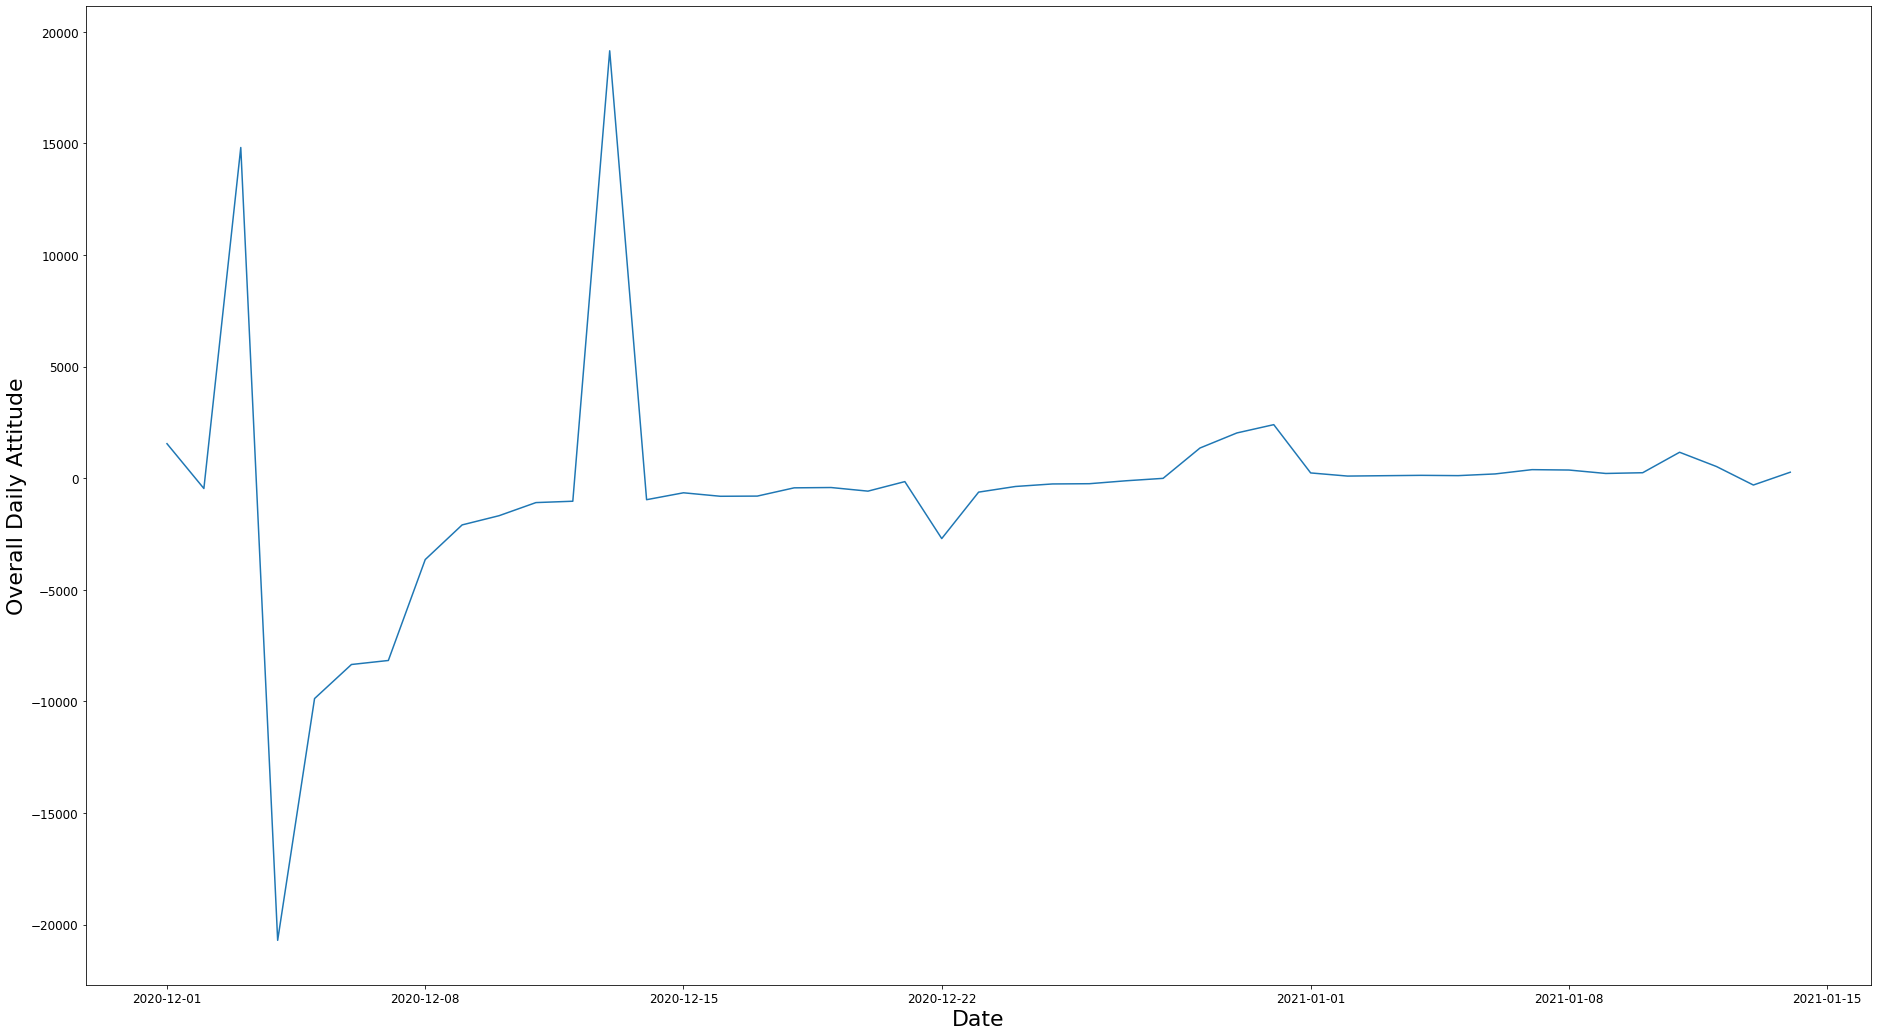

In [28]:
df4 = df[(df["date"] >= "2020-12-01") & (df["date"] < "2021-01-15")]

x = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in list(df4["date"].drop_duplicates())]
y = df4.groupby("date")["overall"].sum().tolist()

plt.plot(x, y)
plt.xlabel("Date", fontsize = 22)
plt.ylabel("Overall Daily Attitude", fontsize = 22)
plt.show()

In [29]:
# 高点赞评论发生情绪误判，原句“三天前4.3万评论，骂了三天，变成了4.2万评论”内涵删评但表面上负面倾向不明显
# df[df["date"] == "2020-12-13"].to_csv("Data/20201213.csv")

### Average User Level

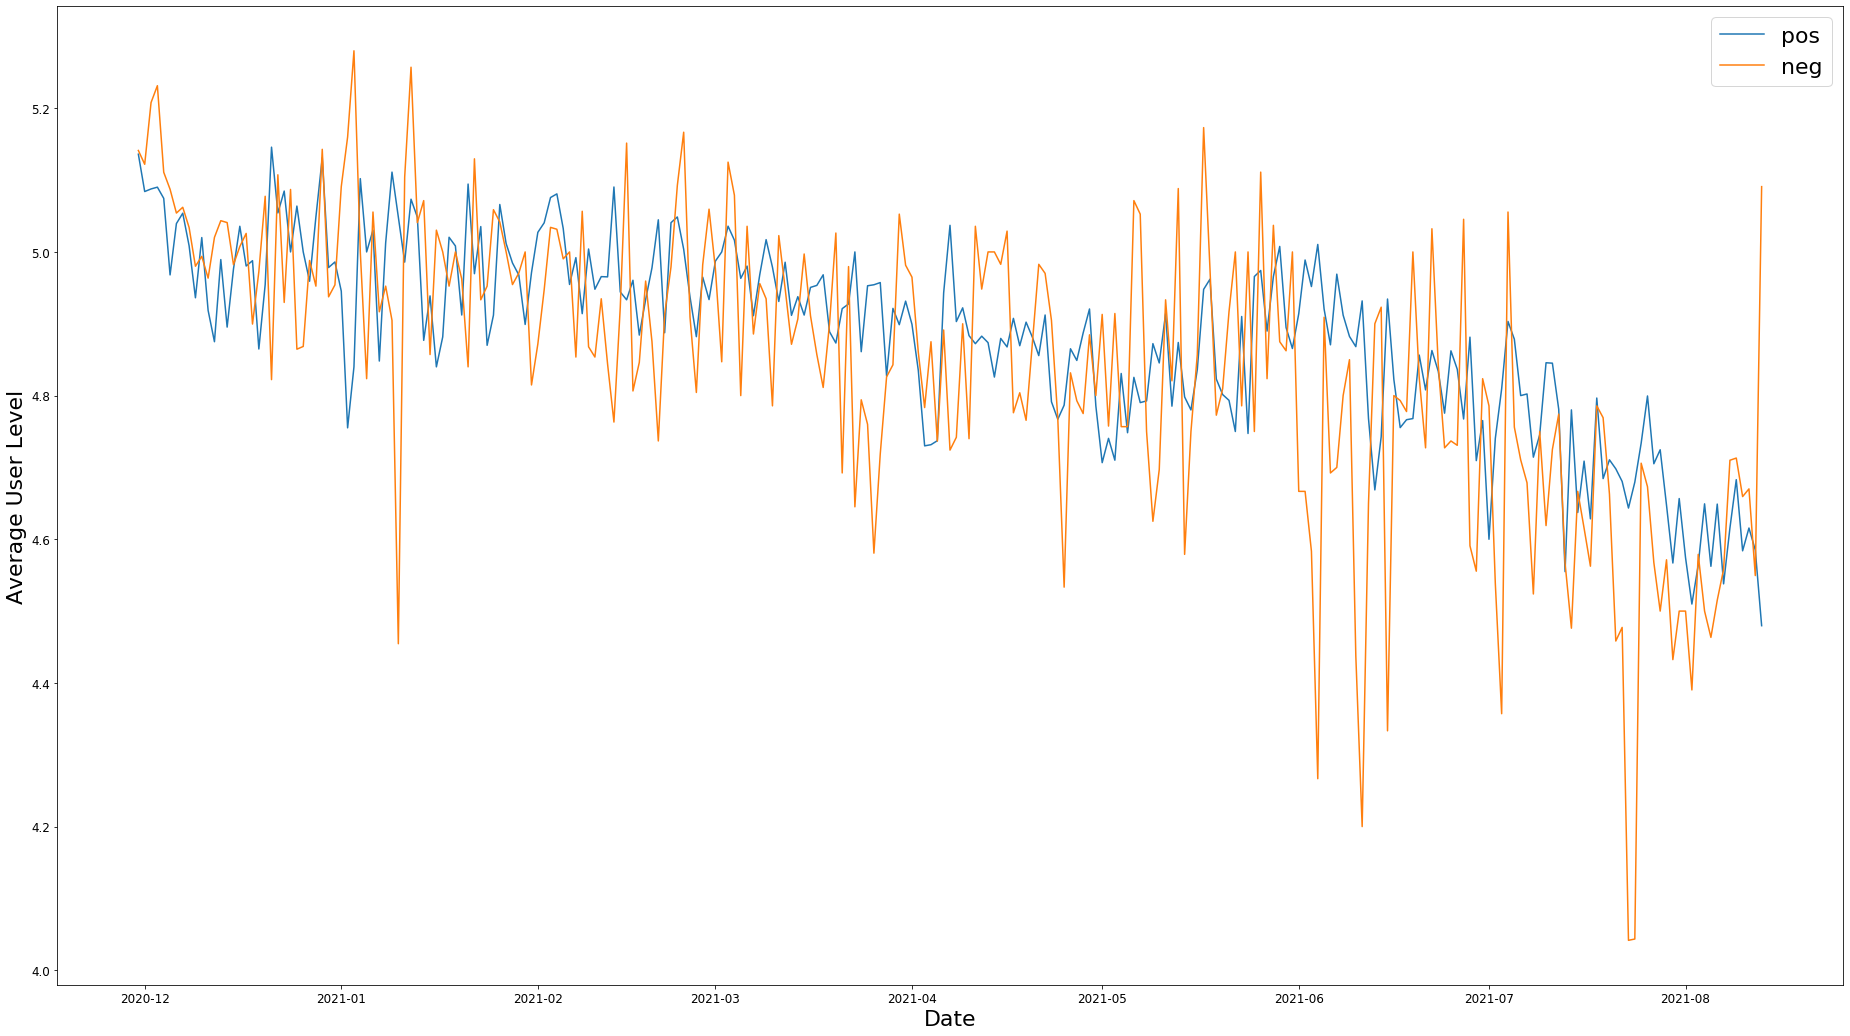

In [30]:
x = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in list(df["date"].drop_duplicates())]
s1 = df[df["sentiment"] == 1].groupby("date")["level"].sum().tolist()
c1 = df[df["sentiment"] == 1].groupby("date")["level"].count().tolist()
y1 = [s1[i] / c1[i] for i in range(len(s1))]
s2 = df[df["sentiment"] == -1].groupby("date")["level"].sum().tolist()
c2 = df[df["sentiment"] == -1].groupby("date")["level"].count().tolist()
y2 = [s2[i] / c2[i] for i in range(len(s2))]

plt.plot(x, y1, label = "pos")
plt.plot(x, y2, label = "neg")
plt.legend(fontsize = 22)
plt.xlabel('Date', fontsize = 22)
plt.ylabel('Average User Level', fontsize = 22)
plt.show()